In [30]:
#Basic pre-reqs:
import numpy as np
import torch
import time
from torch.autograd import Variable
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from celluloid import Camera
from copy import deepcopy as copy
%matplotlib inline

import os

#!pip install celluloid

#!export CUDA=cu101 && pip install --upgrade torch-scatter==latest+${CUDA} torch-sparse==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-1.7.0.html
#!pip install --upgrade torch-geometric

# Mount your google drive in google colab
#from google.colab import drive
#drive.mount('/content/drive')

#%cd '/content/drive/MyDrive/ColabNotebooks/MLAM/GN_ABPs'

import models
import simulate

from sklearn.model_selection import train_test_split

import networkx as nx
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.utils import to_networkx

from models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

from torch_geometric.data import Data, DataLoader
# from models import get_edge_index

from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

from tqdm import tqdm

import numpy as onp
onp.random.seed(0)

import pandas as pd


batch 7
we remove edges of particles following this probability:


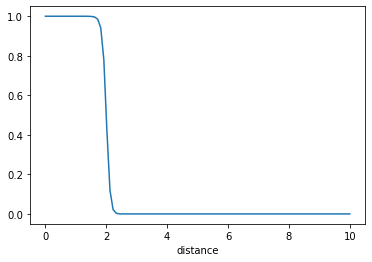

In [31]:
###########################
##    GLOBAL VARIABLES   ##
###########################

### SIMULATIONS ###

# Number of simulations to run (it's fast, don't worry):
ns = 1000

# Potential (see below for options)
sim = 'r2' #'spring'

# Number of nodes
n = 12

# Dimension
dim = 2

# Number of time steps (for some reason later it uses nt/2).
nt = 1000

# Time step
dt = 0.01

# train on data every #int_subsampling snapshots
int_subsampling = 5


# removing edges between particles that are further than a cutoff:\
d_cutoff_TF = 'smooth' #'strict' # False #False/strict/smooth
d_cutoff = 2
d_cutoff_smth = 0.25



### OPTIMIZATION ###
# every step of the minimization the algorithm take a big graph 
# made out of #batch disconnected graphs
# n: number of nodes (particles).
# batch size scales as n^-2 to compensate for the number of messages that goes as n(n-1)
batch =  int(64 * (4 / n)**2) 
print('batch',batch)

# Set up optimizer and training parameters: Use 200 epochs for full version; can use fewer for test.
init_lr = 1e-3
# With total_epochs=200, batch_per_epoch=2000 it takes ~13h.
total_epochs = 50
# number of graphs (snapshots) we include in the test data set
num_graphs_test  = 1000


def fermi_func(x):
    # x is the square of the distance 
    return 1/(np.e**((x-d_cutoff**2)/d_cutoff_smth)+1)


if d_cutoff_TF == 'smooth':

    print('we remove edges of particles following this probability:')
    plt.figure()
    x_pl = np.linspace(0,10,100)
    y_pl = fermi_func(x_pl**2)
    plt.plot(x_pl,y_pl)
    plt.xlabel('distance')
    plt.show()
    

# Custom data loader
# HERE WE GENERATE THE CONECTIVITY TENSOR

get_edge_index_fully_connected = get_edge_index(n, sim)

def get_edge_index_cutoff(X_train,d_cutoff, d_cutoff_TF=True):
    
    if d_cutoff_TF == 'strict':

        mat_x = np.tile(X_train[:,0],(len(X_train[:,0]),1))
        mat_y = np.tile(X_train[:,1],(len(X_train[:,1]),1))

        distances = np.square(mat_x-mat_x.T)+np.square(mat_y-mat_y.T)
        distances[distances <= d_cutoff**2 ] = 1
        distances[distances > d_cutoff**2 ] = 0
        np.fill_diagonal(distances, 0)

        edge_index = torch.from_numpy(np.array(np.where(distances)))
        
    elif d_cutoff_TF == 'smooth':
        
        mat_x = np.tile(X_train[:,0],(len(X_train[:,0]),1))
        mat_y = np.tile(X_train[:,1],(len(X_train[:,1]),1))

        distances = np.square(mat_x-mat_x.T)+np.square(mat_y-mat_y.T)
        
        distances[ fermi_func(distances) >= np.random.rand(*distances.shape) ] = 1
        distances[ fermi_func(distances) < np.random.rand(*distances.shape) ] = 0
        
        np.fill_diagonal(distances, 0)

        edge_index = torch.from_numpy(np.array(np.where(distances)))
        
    else:
        edge_index = get_edge_index_fully_connected
        
    return edge_index



In [32]:

title = '{}_n={}_dim={}_nt={}_dt={}_ns={}'.format(sim, n, dim, nt, dt, ns)
print('Running on', title)

saving_folder = title+'_epochs_'+'{0}_d_cutoff_{1}_{2:1.2f}_d_cutoff_smth_{3:1.2f}'.format(total_epochs,d_cutoff_TF,d_cutoff,d_cutoff_smth)
print('saving_folder ',saving_folder)
os.mkdir(saving_folder)

Running on r2_n=12_dim=2_nt=1000_dt=0.01_ns=1000
saving_folder  r2_n=12_dim=2_nt=1000_dt=0.01_ns=1000_epochs_50_d_cutoff_smooth_2.00_d_cutoff_smth_0.25


In [33]:
#############
# FUNCTIONS #
#############

# Loss function: This holds definition of our L1 and KL regularizations:

def new_loss(self, g, augment=True, square=False):
  if square:
      return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
  else:
      base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
      if test in ['_l1_', '_kl_']:
          s1 = g.x[self.edge_index[0]]
          s2 = g.x[self.edge_index[1]]
          if test == '_l1_':
              m12 = self.message(s1, s2)
              regularization = 1e-2
              #Want one loss value per row of g.y:
              normalized_l05 = torch.sum(torch.abs(m12))
              return base_loss, regularization * batch * normalized_l05 / n**2 * n
          elif test == '_kl_':
              regularization = 1
              #Want one loss value per row of g.y:
              tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
              raw_msg = self.msg_fnc(tmp)
              mu = raw_msg[:, 0::2]
              logvar = raw_msg[:, 1::2]
              full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
              return base_loss, regularization * batch * full_kl / n**2 * n
      return base_loss


# Function to record messages from model


def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] # (pos, vel, ...) of nodes corresponding to indeces tmp.edge_index[0]
        s2 = tmp.x[tmp.edge_index[1]] # same, tmp.edge_index[0] and tmp.edge_index[1] are the nodes forming edges
        
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp) # it applies the first NN to the variables of the nodes forming edges
                                   # the output will have dimension msg_dim (100 in this case)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')] # labels ['x1', 'y1', 'vx1', 'vy1', 'q1', 'm1', 'x2', 'y2', 'vx2', 'vy2', 'q2', 'm2']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]

        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )
    
    

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info


# Function to visualize network

def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        print("isTensor")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        print("isNotTensor")
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

    
# Functions to import LAMMPs data.

import glob, re

def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower()
            for text in _nsre.split(s)] 

def importFiles(filename_glob_pattern, dtype=None, delimiter=None, skip_header=0, usecols=None):
    sorted_file_list = sorted(glob.glob(filename_glob_pattern), key=natural_sort_key)
    data = []
    for file_path in sorted_file_list:
        data.append(
            np.genfromtxt(file_path, delimiter=delimiter, skip_header=skip_header, dtype=dtype, usecols=usecols))
    print("Imported {} files.".format(len(data)))
        
    return data

def lammpsDump2numpy(frames):
    data = np.asarray(frames);
    data_attr = np.array([[[np.concatenate((row[2:6], np.array([0,1]))) for row in col] for col in data]]);
    data_accel = np.array([[[row[6:8] for row in col] for col in data]]);
    
    return data_attr, data_accel

In [34]:
# Run one of the two following cells.

In [35]:
# Generate simulation data with their JAX simulations (see simulate.py).

import importlib
importlib.reload(simulate)

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
{'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
{'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'BD', 'dt': [1e-5], 'nt': [2001], 'n': n_set, 'dim': [2, 3]},
]

#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

# ??? Why nt//2
from simulate import SimulationDataset
s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt) 

# Update this to your own dataset, or regenerate:
base_str = './'
data_str = title
s.simulate(ns)

# data has [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
data_attr  = s.data
data_accel = s.get_acceleration()

print("Attr shape: [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]] ")
print(data_attr.shape)
print("Accl shape: [simulation ID, time, particle ID, [accelx, accely]] ")
print(data_accel.shape)


Attr shape: [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]] 
(1000, 500, 12, 6)
Accl shape: [simulation ID, time, particle ID, [accelx, accely]] 
(1000, 500, 12, 2)


dt 0.001
(1000, 500, 12, 6)


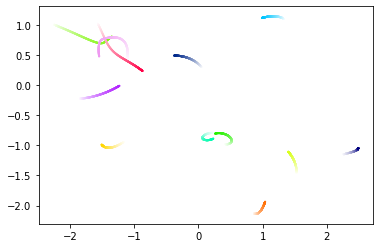

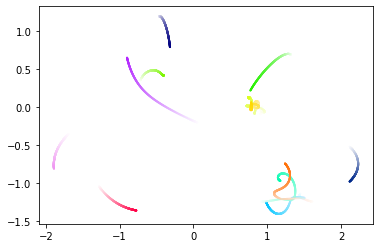

In [36]:
print('dt',dt)
data = s.data
print(s.data.shape)
s.plot(1, animate=False, plot_size=False)
plt.show()
s.plot(2, animate=False, plot_size=False)
# s.plot(10000, animate=True, plot_size=False)

In [37]:
# # Use LAMMPs simulation data

# import importlib
# importlib.reload(simulate)

# # Number of simulations to run (it's fast, don't worry):
# ns = 1

# # Potential (see below for options)
# sim = 'r2'

# # Number of nodes
# n = 25

# # Dimension
# dim = 2

# # Number of time steps
# nt = 2001

# # Time step

# dt = 0.01

# #Standard simulation sets:
# n_set = [4, 8]
# sim_sets = [
# {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
# {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
# {'sim': 'BD', 'dt': [1e-5], 'nt': [2001], 'n': n_set, 'dim': [2, 3]},
# ]

# # Import LAMMPs data (passive system, Pe=1e-6).
# fileNamePatt="../../lammps/data/20210310_small_system/Tsim1.00e+07_dt1.00e-05_N2.50e+01_phi3.00e-01_Pe1.00e-06_Fp2.40e+01_KT2.90e-01_Dt1.50e+00/Frames/frame.*"
# frames = importFiles(fileNamePatt, dtype=None, delimiter=" ", skip_header=9, usecols=range(0,8))

# # Transform LAMMPs data to PyTorch format:
# # data_attr: [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
# # data_acccel: [simulation ID, time, particle ID, [accelx, accely]]

# data = np.asarray(frames);
# data_attr = np.array([[[np.concatenate((row[2:6], np.array([idx,1]))) for row in col] for idx, col in enumerate(data)]]);
# data_accel = np.array([[[row[6:8] for row in col] for col in data]]);

# data_attr, data_accel = lammpsDump2numpy(frames)

# print("Attr shape: {} ".format(data_attr.shape))
# print("Accl shape: {} ".format(data_accel.shape))

In [38]:
# Put data in PyTorch format
X = torch.from_numpy(np.concatenate([data_attr[:,i] for i in range(0, data_attr.shape[1], int_subsampling)]))
y = torch.from_numpy(np.concatenate([data_accel[:, i] for i in range(0, data_accel.shape[1], int_subsampling)]))

X=X.type(torch.FloatTensor)
y=y.type(torch.FloatTensor)

print("Attr. (X) shape: {}".format(X.shape))
print("Accl. (y) shape: {}".format(y.shape))

Attr. (X) shape: torch.Size([100000, 12, 6])
Accl. (y) shape: torch.Size([100000, 12, 2])


In [39]:
# Here we divide train and test data, by default it selects 25% of the data as
# test data. It seems that this is the last 25% of the systems time evolution.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([75000, 12, 6])
torch.Size([25000, 12, 6])
torch.Size([75000, 12, 2])
torch.Size([25000, 12, 2])


# **Training**

In [40]:

# L1 regularization

aggr = 'add'
hidden = 300
test = '_l1_'

#This test applies an explicit bottleneck:
msg_dim = 100

n_f = data_attr.shape[3]


In [41]:


# Initiate the model

#######
# GPU #
#######

# if test == '_kl_':
#     ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
# else:
#     ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()

# messages_over_time = []
# ogn = ogn.cuda()

# Test the model
# _q = Data(
#     x=X_train[0].cuda(),
#     edge_index=edge_index.cuda(),
#     y=y_train[0].cuda())
# ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 



#######
# CPU #
#######

if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()

messages_over_time = []
ogn = ogn.cpu()



In [42]:

# # Test the model
# _q = Data(
#     x=X_train[0].cpu(),
#     edge_index=edge_index.cpu(),
#     y=y_train[0].cpu())
# ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 


In [43]:


## Set up training

time_1 = time.time()

# one minibatch has #batch disconnected graphs
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=get_edge_index_cutoff(X_train[i],d_cutoff,d_cutoff_TF=d_cutoff_TF),
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)


testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=get_edge_index_cutoff(X_test[i],d_cutoff,d_cutoff_TF=d_cutoff_TF),
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

time_2 = time.time()

print('computation time: ', time_2-time_1)




/home/miguel/miniconda3/envs/mlam_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in power


computation time:  16.603827476501465


In [44]:

print('batch',batch)
print('len(y_train)',len(y_train))
# print('ginput.batch',ginput.batch)


i=0
for ginput in trainloader:     # Trainloader has the 1500 samples (pos vel edge index, ...).
    if i >= 3:
        break
    print('number of edges in a batch in the fully conencted case: n*(n-1)*batch ', n*(n-1)*batch)
    print('number of edges in this batch: ',np.shape(ginput.edge_index))
    
    i+=1
    

batch 7
len(y_train) 75000
number of edges in a batch in the fully conencted case: n*(n-1)*batch  924
number of edges in this batch:  torch.Size([2, 666])
number of edges in a batch in the fully conencted case: n*(n-1)*batch  924
number of edges in this batch:  torch.Size([2, 695])
number of edges in a batch in the fully conencted case: n*(n-1)*batch  924
number of edges in this batch:  torch.Size([2, 559])


In [45]:
print(len(trainloader.dataset))
print(len(testloader.dataset))

# edge_index has dimensions [2, num_nodes^2 - num_nodes]
print('links of fully connected graph: ',n*(n-1))
print(trainloader.dataset[0])
print(testloader.dataset[0])

75000
25000
links of fully connected graph:  132
Data(edge_index=[2, 74], x=[12, 6], y=[12, 2])
Data(edge_index=[2, 78], x=[12, 6], y=[12, 2])


In [46]:

# We'll use OneCycleLR for fast training:

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# batch_per_epoch = int(1000*10 / (batch/32.0))
batch_per_epoch = int(len(trainloader.dataset)/batch) 

print('batch_per_epoch',batch_per_epoch)
print('batch',batch)
print('batch*batch_per_epoch',batch*batch_per_epoch)
print('len(trainloader.dataset)',len(trainloader.dataset))
print('len(y_train)',len(y_train))


batch_per_epoch 10714
batch 7
batch*batch_per_epoch 74998
len(trainloader.dataset) 75000
len(y_train) 75000


In [47]:

sched = OneCycleLR(opt, max_lr=init_lr,
                  steps_per_epoch=batch_per_epoch,#len(trainloader),
                  epochs=total_epochs, final_div_factor=1e5)

epoch = 0

# Organize the recording of messages over time This is for fitting the forces, and extracting laws:

test_idxes = onp.random.randint(0, len(X_test), num_graphs_test)



#Record messages over test dataset here:
# 1000 snapshots taken at random (if 4 particles this is 12000 messages)

newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=get_edge_index_cutoff(X_test[i],d_cutoff,d_cutoff_TF=d_cutoff_TF),
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

# idxarr=-1*np.ones((11,151), int);

### Train the model:
# Training loop
recorded_models = []
recorded_times = []
recorded_loss = []


/home/miguel/miniconda3/envs/mlam_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in power


In [ ]:


start_time = time.time()
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cpu()
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:     # Trainloader has the 1500 samples (pos vel edge index, ...).
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x.cpu()
            ginput.y = ginput.y.cpu()
            ginput.edge_index = ginput.edge_index.cpu()
            ginput.batch = ginput.batch.cpu()
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()
            total_loss += loss.item()
            
#             idxarr[epoch,i]= ginput.x[0,4]
            
            i += 1
            print("Epoch: {} ({}%) - {}".format(epoch, 100*i/batch_per_epoch, ginput.x[0,4]), flush=True, end='\r')
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print('cur_loss',cur_loss)
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()

    recorded_models.append(ogn.state_dict()) # it saves #epoch copies of the last model!!!
    recorded_times.append(epoch)
    recorded_loss.append(cur_loss)
    
    torch.save(ogn.state_dict(), os.path.join(saving_folder, 'epoch-{0}.pth'.format(epoch)))


  0%|          | 0/50 [00:00<?, ?it/s]

cur_loss 846.77583072218514%) - 0.0000


  2%|▏         | 1/50 [46:37<38:04:38, 2797.52s/it]

cur_loss 786.71080933007824%) - 0.0000


  4%|▍         | 2/50 [1:32:34<36:58:58, 2773.72s/it]

cur_loss 747.94733208917474%) - 0.0000


  6%|▌         | 3/50 [2:16:47<35:29:33, 2718.59s/it]

cur_loss 727.01958701483344%) - 0.0000


  8%|▊         | 4/50 [3:02:45<34:56:15, 2734.25s/it]

cur_loss 684.23305711390424%) - 0.0000


 10%|█         | 5/50 [3:47:23<33:55:30, 2714.00s/it]

In [ ]:
5*3

# **Analysis**

In [ ]:

#Only turn on one of these:
plot_force_components = True
plot_sparsity = False
plot_rotation = False
if plot_force_components:
    fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
if plot_sparsity or plot_rotation:
    fig, ax = plt.subplots(1, 1)
cam = Camera(fig)


last_alpha_x1 = 0.0
last_alpha_y1 = 0.0


msgs = copy(messages_over_time[0])
print('msgs.dtypes',msgs.dtypes[0:13])
print('98 messages e1, e2...')
print('msgs.dtypes',msgs.dtypes[-6:-1])
print('our test daat set has 1000 samples of 12 edges each',np.shape(msgs))


In [ ]:


t = lambda _: _#tqdm

for i in t(range(0, total_epochs, 1)): #len(messages_over_time) number of epochs
#     msgs = copy(messages_over_time[i])

    load_file = os.path.join(saving_folder, 'epoch-{0}.pth'.format(i))
    print('loading ',load_file)
    ogn.load_state_dict(torch.load(load_file))
    cur_msgs = get_messages(ogn)
    
    msgs = copy(cur_msgs)

    msgs['bd'] = msgs.r + 1e-2 # distance between two particles, I guess we sum 1e-2 to prevent divisions by 0?

    #we take only the messages corresponding to forces
    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    print('most_important',most_important)
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    if plot_sparsity:
        ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
        # plt.colorbar()
        plt.axis('off')
        plt.grid(True)
        ax.set_aspect('equal')
        plt.text(15.5, 0.5, '...', fontsize=30)
        # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
        plt.tight_layout()
    
    if plot_force_components or plot_rotation:
        pos_cols = ['dx', 'dy']
        if dim == 3:
            pos_cols.append('dz')

        if sim == 'spring':
            force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        elif sim == 'r2':
            force_fnc = lambda msg: np.array(msg[pos_cols]) / (msg.bd[:, None])**3.0 #masses equal to 1
        else:
            raise NotImplementedError("The current force function is for a spring. You will need to change the force function below to that expected by your simulation.")
        
        
        expected_forces = force_fnc(msgs)

        def percentile_sum(x):
            x = x.ravel()
            bot = x.min()
            top = np.percentile(x, 90)
            msk = (x>=bot) & (x<=top)
            frac_good = (msk).sum()/len(x)
            return x[msk].sum()/frac_good

        from scipy.optimize import minimize

        def linear_transformation_2d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
            )/2.0

            return score

        def out_linear_transformation_2d(alpha):
            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            return lincomb1, lincomb2

        def linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
                percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
            )/3.0

            return score

        def out_linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            return lincomb1, lincomb2, lincomb3

        if dim == 2:
            min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
        if dim == 3:
            min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
        print(title, test, 'gets', min_result.fun/len(msgs))

        if plot_rotation:
            q = min_result.x
            alphax1, alphay1, offset1 = q[:3]
            alphax2, alphay2, offset2 = q[3:]
            
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            
            if (
                    (alphax2 - last_alpha_x1)**2
                    + (alphay2 - last_alpha_y1)**2  <
                   (alphax1 - last_alpha_x1)**2
                    + (alphay1 - last_alpha_y1)**2):
                
                alphax1, alphay1, offset1 = q[3:]
                alphax2, alphay2, offset2 = q[:3]
                
            last_alpha_x1 = alphax1
            last_alpha_y1 = alphay1
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            alphax1 /= s1**0.5 * 2
            alphay1 /= s1**0.5 * 2
            alphax2 /= s2**0.5 * 2
            alphay2 /= s2**0.5 * 2
            
            ax.arrow(0.5, 0.5, alphax1, alphay1, color='k', head_width=0.05, length_includes_head=True)
            ax.arrow(0.5, 0.5, alphax2, alphay2, color='k', head_width=0.05, length_includes_head=True)
            ax.axis('off')
        
        if plot_force_components:
            for i in range(dim):
                if dim == 3:
                    px = out_linear_transformation_3d(min_result.x)[i]
                else:
                    px = out_linear_transformation_2d(min_result.x)[i]

                py = msgs_to_compare[:, i]
                ax[i].scatter(px, py,
                              alpha=0.1, s=0.1, color='k')
                ax[i].set_xlabel('Linear combination of forces')
                ax[i].set_ylabel('Message Element %d'%(i+1))

                xlim = np.array([np.percentile(px, q) for q in [10, 90]])
                ylim = np.array([np.percentile(py, q) for q in [10, 90]])
                xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
                ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
                
#                 ax[i].set_xlim((-1,1))
#                 ax[i].set_ylim((-1,1))
                
        plt.tight_layout()
    
    cam.snap()

ani = cam.animate()
    
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
# For CPU

from simulate import make_transparent_color
from scipy.integrate import odeint

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
camera = Camera(fig)


for current_model in [0,total_epochs-1]: # current_model<=-2 corresponds to Random model!
    i = 1 #4 #2 #Use this simulation
    if current_model > total_epochs-1:
        continue

    #Truth:
    cutoff_time =  nt//2  #300
    times = onp.array(s.times)[:cutoff_time]
    x_times = onp.array(data[i, :cutoff_time])
    masses = x_times[:, :, -1]
    length_of_tail = 75

    #Learned:
    e = get_edge_index_cutoff(1,1,d_cutoff_TF=False).cpu() #change by d_cutoff_TF=True???
#     ogn.cpu()
    if current_model > -2:
#         ogn.load_state_dict(recorded_models[current_model])
        load_file = os.path.join(saving_folder, 'epoch-{0}.pth'.format(current_model))
        print('loading ',load_file)
        ogn.load_state_dict(torch.load(load_file))
        
        
    else:
        # Random model!
        ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()
#     ogn_new.cpu()
    
    def odefunc(y, t=None):
        y = y.reshape(n, 6).astype(np.float32)
        cur = Data(
            x=torch.from_numpy(y).cpu(),
            edge_index=e
        )
        dx = y[:, 2:4]
        dv = ogn.just_derivative(cur).cpu().detach().numpy()
        dother = np.zeros_like(dx)
        return np.concatenate((dx, dv, dother), axis=1).ravel()

    datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, n, 6)
    x_times2 = onp.array(datai)

    d_idx = 10
    for t_idx in range(d_idx, cutoff_time, d_idx):
        start = max([0, t_idx-length_of_tail])
        ctimes = times[start:t_idx]
        cx_times = x_times[start:t_idx]
        cx_times2 = x_times2[start:t_idx]
        for j in range(n):
            rgba = make_transparent_color(len(ctimes), j/n)
            ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba) #left plot is the true movement
            ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba) #right plot predicted movement
            black_rgba = rgba
            black_rgba[:, :3] = 0.75
            ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1) # right plot grey -> true movement

        for k in range(2):
            ax[k].set_xlim(-3, 3)
            ax[k].set_ylim(-3, 3)
        plt.tight_layout()
        camera.snap()
        
        if t_idx > cutoff_time-d_idx:
            fig.title('current_model {0}'.format(current_model))

# camera.animate().save('multiple_animations_with_comparison.mp4')
from IPython.display import HTML
HTML(camera.animate().to_jshtml())



In [ ]:
# messages_over_time = [0,1,2,3,4,5]

for i in t(range(0, total_epochs, 1)): #len(messages_over_time) number of epochs
    
    load_file = os.path.join(saving_folder, 'epoch-{0}.pth'.format(i))
    print('loading ',load_file)
    ogn.load_state_dict(torch.load(load_file))
    cur_msgs = get_messages(ogn)
    
    msgs = copy(cur_msgs)

    msgs['bd'] = msgs.r + 1e-2 # distance between two particles, I guess we sum 1e-2 to prevent divisions by 0?

    #we take only the messages corresponding to forces
    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    print('most_important',most_important)
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    
newtestloader_2 = DataLoader(
    [Data(
        X_test[i],
        edge_index=get_edge_index_cutoff(X_test[i],d_cutoff,d_cutoff_TF=False),
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

print(np.shape(X_test))

i=0
for ginput_plot_all in newtestloader_2:     # Trainloader has the 1500 samples (pos vel edge index, ...).
    print('i ', i)
    if i >= 2:
        print('break')
        break

    print('number of messages if fully connected graphs: ', num_graphs_test*n*(n-1))
    print(np.shape(ginput_plot_all.edge_index))
    i+=1
    
    
    
newtestloader_3 = DataLoader(
    [Data(
        X_test[i],
        edge_index=get_edge_index_cutoff(X_test[i],d_cutoff,d_cutoff_TF=d_cutoff_TF),
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

print(np.shape(X_test))

i=0
for ginput_plot_cutoff in newtestloader_3:     # Trainloader has the 1500 samples (pos vel edge index, ...).
    print('i ', i)
    if i >= 2:
        print('break')
        break

    print('number of messages if fully connected graphs: ', num_graphs_test*n*(n-1))
    print(np.shape(ginput_plot_cutoff.edge_index))
    i+=1
    
    

In [ ]:


# TRYING TO PLOT THE FORCE

def plotting_force(ginput_plot, epoch_pl_list = [0,2]):

    s1 = ginput_plot.x[ginput_plot.edge_index[0,:]]
    s2 = ginput_plot.x[ginput_plot.edge_index[1,:]]
    
    print('np.shape(s1)',np.shape(s1))
    print('np.shape(s2)',np.shape(s2))
    
    distance = (s1[:,0:2]-s2[:,0:2]).detach().numpy()
    print('np.shape(distance)',np.shape(distance))
    distance_mod = np.linalg.norm(distance,axis=1)
    print('np.shape(distance_mod)',np.shape(distance_mod))
    

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('distance')
    ax1.set_ylabel('count', color=color)
    logbins = np.logspace(np.log10(min(distance_mod)),np.log10(max(distance_mod)),50)
    ax1.hist(distance_mod, bins = logbins, color=color)
    ax1.set_xscale('log')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'

    x_pl = np.linspace(0,10,100)
    y_pl = fermi_func(x_pl**2)
    ax2.plot(x_pl,y_pl)
    ax2.set_ylabel('Prob considering edge', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)

    ax2.set_xlim((0.001,100))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
    for epoch_pl in epoch_pl_list:

        load_file = os.path.join(saving_folder, 'epoch-{0}.pth'.format(epoch_pl))
        print('loading ',load_file)
        ogn.load_state_dict(torch.load(load_file))
        print('ogn.edge_index[0]',ogn.edge_index[0,0])

        force = ogn.message(s1, s2)[:,most_important].detach().numpy()
        force_mod = np.linalg.norm(force,axis=1)
        print('np.shape(force_mod)',np.shape(force_mod))

        plt.figure()
        plt.plot(distance_mod,force_mod,'.')
        xxx = np.linspace(0.1, 1, 10)
        yyy = 1/xxx**2
        plt.plot(xxx,yyy,'--')

        ax = plt.gca()
        ax.set_xscale('log')
        ax.set_yscale('log')
        plt.xlabel('distance')
        plt.ylabel('force')
        plt.xlim((0.001,100))
        plt.show()
    
    
plotting_force(ginput_plot_all, epoch_pl_list = [0,total_epochs-1])
plotting_force(ginput_plot_cutoff, epoch_pl_list = [0,total_epochs-1])

In [ ]:
# # For GPU

# fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# camera = Camera(fig)

# for current_model in [-1] + [1, 34, 67, 100, 133, 166, 199]:
#     i = 4 #Use this simulation
#     if current_model > len(recorded_models):
#         continue

#     #Truth:
#     cutoff_time = 300
#     times = onp.array(s.times)[:cutoff_time]
#     x_times = onp.array(data[i, :cutoff_time])
#     masses = x_times[:, :, -1]
#     length_of_tail = 75

#     #Learned:
#     e = edge_index.cuda()
#     ogn.cpu()
#     if current_model > -1:
#         ogn.load_state_dict(recorded_models[current_model])
#     else:
#         # Random model!
#         ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
#     ogn.cuda()
    
#     def odefunc(y, t=None):
#         y = y.reshape(n, 6).astype(np.float32)
#         cur = Data(
#             x=torch.from_numpy(y).cuda(),
#             edge_index=e
#         )
#         dx = y[:, 2:4]
#         dv = ogn.just_derivative(cur).cpu().detach().numpy()
#         dother = np.zeros_like(dx)
#         return np.concatenate((dx, dv, dother), axis=1).ravel()

#     datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, n, 6)
#     x_times2 = onp.array(datai)

#     d_idx = 10
#     for t_idx in range(d_idx, cutoff_time, d_idx):
#         start = max([0, t_idx-length_of_tail])
#         ctimes = times[start:t_idx]
#         cx_times = x_times[start:t_idx]
#         cx_times2 = x_times2[start:t_idx]
#         for j in range(n):
#             rgba = make_transparent_color(len(ctimes), j/n)
#             ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba)
#             ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba)
#             black_rgba = rgba
#             black_rgba[:, :3] = 0.75
#             ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1)

#         for k in range(2):
#             ax[k].set_xlim(-1, 3)
#             ax[k].set_ylim(-3, 1)
#         plt.tight_layout()
#         camera.snap()

# # camera.animate().save('multiple_animations_with_comparison.mp4')
# from IPython.display import HTML
# HTML(camera.animate().to_jshtml())

In [ ]:
#######################
# Symbolic regression #
#######################

In [ ]:
# Finally, one can install a free 30-day trial of Eureqa at this URL: https://www.nutonian.com/download/eureqa-desktop-download/.

# Extract the force laws with the following procedure:

#     The data in messages_over_time correspond to inputs to, and features of, ϕe, recorded during each training epoch.
#     Select the last element of this list.
#     Find the most significant message feature. Each message feature corresponds to 'e1', 'e2', etc. Calculate the one with the largest standard deviation.
#     Save that message to csv file along with the input features. Paste these into the data column of Eureqa (it's a GUI app).
#     Don't change anything on the "prepare data" tab.
#     Enable your choice of operators with complexity levels for each (this choice is up to you).
#     Set the loss to mean absolute error (the default) and begin training.
#     After you start training, you will be able to see a table of equations as a function of complexity and fit to the data. These represent a symbolic representation of the message function.
#     Find the equation that has the greatest drop in log mean absolute error over increase in complexity. This equation should be equal to a linear transform of the true force.

# Thus, we have extracted a force law from the graph network without priors on the functional form.

# This is the same technique we used to extract the unknown dark matter overdensity equation from the Quijote simulations

In [ ]:
# Here's the best message, which we will study:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(100)])

In [ ]:
# Here's a pandas dataframe of the message data:
messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]

In [ ]:
# Now we just fit e4 as a function of dx, dy, r, m1, and m2, inside Eureqa.